In [1]:
#!Get-Item Env:HUGGINGFACE_TOKEN
#!huggingface-cli login --token $HUGGINGFACE_TOKEN

#AFAICT this is straight up broken on Windows, I just logged manually via a terminal window 

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
use_SD3 = True
use_SD1 = not(use_SD3)

drop_t5 = True

if use_SD3:
    from diffusers import StableDiffusion3Pipeline
    if not(drop_t5):
        pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
    else:
        pipe = StableDiffusion3Pipeline.from_pretrained(
            "stabilityai/stable-diffusion-3-medium-diffusers", 
            text_encoder_3=None,
            tokenizer_3=None,
            torch_dtype=torch.float16
        )

    pipe.to("cuda")

c:\Users\natha\scoop\persist\miniconda3\envs\SD3HF\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\natha\scoop\persist\miniconda3\envs\SD3HF\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]


In [4]:
if use_SD1:
    from diffusers import StableDiffusionPipeline

    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True, torch_dtype=torch.float16)
    pipe.to("cuda")

c:\Users\natha\scoop\persist\miniconda3\envs\SD3HF\Lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


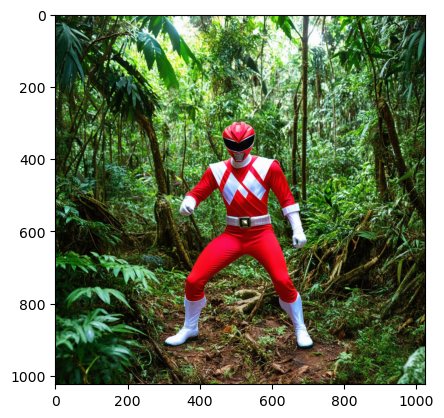

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

prompt_str = "a power ranger in the jungle"

if use_SD3:
    image = pipe(
        prompt=prompt_str,
        negative_prompt="",
        num_inference_steps=28,
        height=1024,
        width=1024,
        guidance_scale=7.0,
    ).images[0]

    #image.save("sd3_hello_world.png")

if use_SD1:
    image = pipe(
        prompt=prompt_str,
    ).images[0]

plt.imshow(image)

Lets breakdown the stable diffusion into its consitutent parts.

First we have the text encoders and tokenizers.

In [6]:
pipe

StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.29.2",
  "_name_or_path": "stabilityai/stable-diffusion-3-medium-diffusers",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    null,
    null
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
#!nvidia-smi

SD1.5 uses 4.7GB of VRAM
SD3 uses 22GB of VRAM
SD3 without T5 uses 11GB of VRAM
SD3 with 8bit quantised T5 uses
SDXL 

In [8]:
if False:
    #CLIP ViT-Large
    print(SD3_pipe.text_encoder)
    print(SD3_pipe.tokenizer)
    #CLIP ViT-Big
    print(SD3_pipe.text_encoder_2)
    print(SD3_pipe.tokenizer_2)
    #T5 v1 XXL
    print(SD3_pipe.text_encoder_3)
    print(SD3_pipe.tokenizer_3)

Next we have the variational autoencoder

In [9]:
if False:
    #Autoencoder KL
    print(SD3_pipe.vae)